# Simple Lens Comparison Figures
This notebook loads CSVs for three methods (`camera_sensor`, `computer_vision_based`, `voltage_sensor`) and produces exactly three figures: one for lens `5`, one for lens `8`, and one for lens `11`, each overlaying the results from all methods.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

CWD = os.path.abspath(os.getcwd())
RESULTS_DIR = CWD if os.path.basename(CWD) == "test_results" else os.path.join(CWD, "test_results")

# METHODS = ["camera_sensor", "computer_vision", "voltage_sensor", "baseline"]
METHODS = ["computer_vision", "voltage_sensor", "baseline"]
LENSES = ["8", "10"]

# Simple CSV loader: use first numeric column or single column
def load_csv_simple(path):
    try:
        df = pd.read_csv(path)
        if df.empty:
            return []
        # Single column
        if df.shape[1] == 1:
            return pd.to_numeric(df.iloc[:, 0], errors="coerce").dropna().tolist()
        # First numeric column
        for col in df.columns:
            if pd.api.types.is_numeric_dtype(df[col]):
                return pd.to_numeric(df[col], errors="coerce").dropna().tolist()
        # Fallback: no header
        df2 = pd.read_csv(path, header=None)
        return pd.to_numeric(df2.iloc[:, 0], errors="coerce").dropna().tolist()
    except Exception as e:
        print(f"Failed to read {path}: {e}")
        return []

# Build data dict: {lens: {method: [values]}}
DATA = {lens: {m: [] for m in METHODS} for lens in LENSES}
for m in METHODS:
    for lens in LENSES:
        path = os.path.join(RESULTS_DIR, m, f"{lens}.csv")
        if os.path.exists(path):
            DATA[lens][m] = load_csv_simple(path)
        else:
            # Keep empty list if missing
            pass

for lens in LENSES:
    counts = {m: len(DATA[lens][m]) for m in METHODS}
    print(f"Lens {lens} counts: {counts}")

Lens 8 counts: {'computer_vision': 4, 'voltage_sensor': 4, 'baseline': 4}
Lens 10 counts: {'computer_vision': 4, 'voltage_sensor': 4, 'baseline': 4}


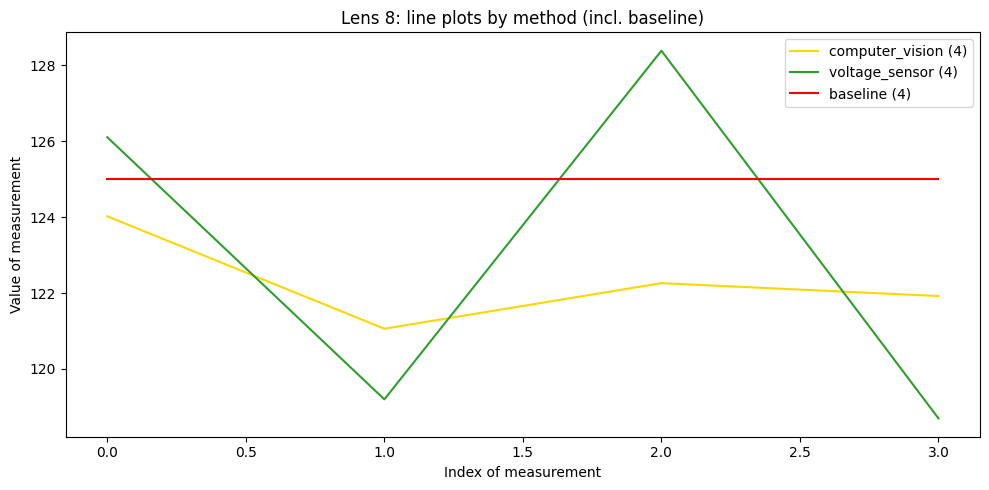

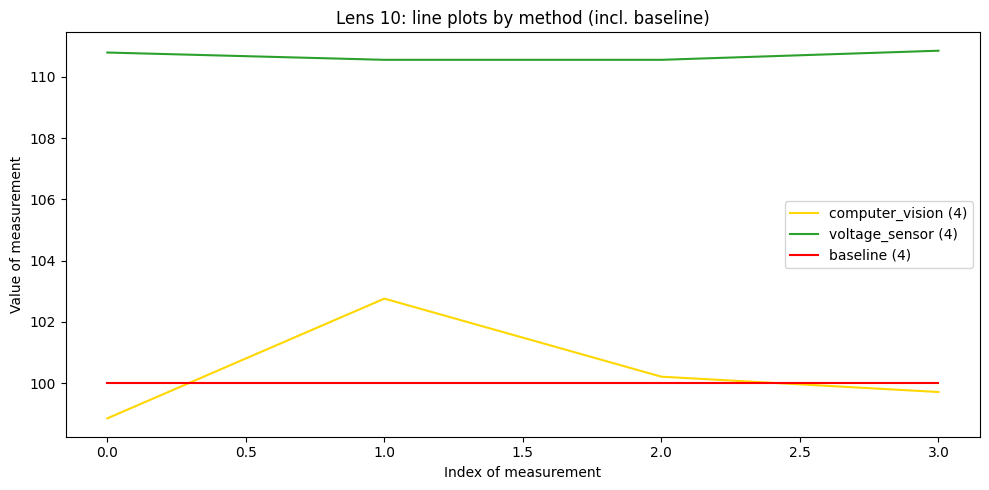

In [2]:
# Three simple figures: lens 5, 8, 11 (line plots)
if all(len(v) == 0 for mdata in DATA.values() for v in mdata.values()):
    print("No data loaded. Ensure CSVs exist under test_results/<method>/<lens>.csv")
else:
    colors = {
        "camera_sensor": "tab:blue",   # blue
        "computer_vision": "gold",  # computer_vision (was 'tab:yellow')
        "voltage_sensor": "tab:green",  # green
        "baseline": "red",  # baseline in red
    }
    label_map = {
        "camera_sensor": "camera_sensor",
        "computer_vision": "computer_vision",
        "voltage_sensor": "voltage_sensor",
        "baseline": "baseline",
    }
    for lens in LENSES:
        plt.figure(figsize=(10, 5))
        plotted = False
        for m in METHODS:
            vals = DATA[lens][m]
            if len(vals) == 0:
                continue
            x = np.arange(len(vals))
            plt.plot(x, vals, label=f"{label_map[m]} ({len(vals)})", color=colors.get(m, None))
            plotted = True
        if not plotted:
            plt.close()
            print(f"No method data to plot for lens {lens}.")
            continue
        plt.title(f"Lens {lens}: line plots by method (incl. baseline)")
        plt.xlabel("Index of measurement")
        plt.ylabel("Value of measurement")
        plt.legend()
        plt.tight_layout()
        plt.show()

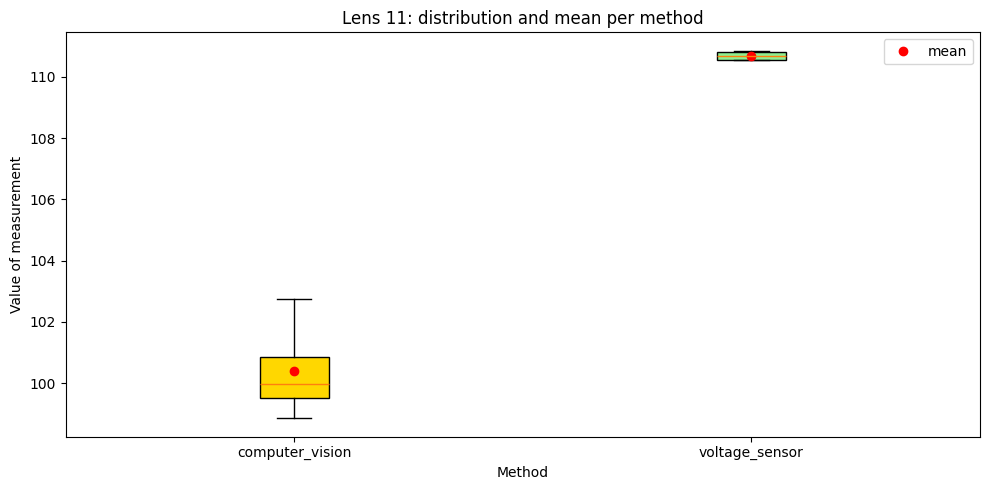

In [3]:
# Single figure: distribution/variance per method for lens 11 only
lens = "10"
methods_core = [m for m in ["camera_sensor", "computer_vision", "voltage_sensor"] if m in DATA[lens]]
if all(len(DATA[lens][m]) == 0 for m in methods_core):
    print("No data for lens 10. Ensure CSVs exist under test_results/<method>/10.csv")
else:
    labels = methods_core
    data = [DATA[lens][m] for m in methods_core]
    positions = range(1, len(data) + 1)
    plt.figure(figsize=(10, 5))
    bp = plt.boxplot(data, positions=positions, patch_artist=True)
    # Color boxes per method (blue, gold, lightgreen)
    color_map = {"camera_sensor": "lightblue", "computer_vision": "gold", "voltage_sensor": "lightgreen"}
    for patch, lbl in zip(bp['boxes'], labels):
        patch.set_facecolor(color_map.get(lbl, "lightgray"))
    means = [np.mean(d) if len(d) > 0 else np.nan for d in data]
    plt.plot(list(positions), means, "o", color="red", label="mean")
    plt.title("Lens 11: distribution and mean per method")
    plt.xlabel("Method")
    plt.ylabel("Value of measurement")
    plt.xticks(list(positions), labels)
    plt.legend()
    plt.tight_layout()
    plt.show()